<a href="https://colab.research.google.com/github/HumbertoChiesi/gc_stats/blob/main/gc_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTES**

In [25]:
!pip install lightgbm
!pip install catboost
!pip install xgboost

In [52]:
import pandas as pd
import numpy as np

from IPython.core.display import HTML

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_selection import f_classif

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# **FUNÇÕES**

In [27]:
# calcula rating conforme os dados passados
def rating(kills, deaths, rounds, k1, k2, k3, k4, k5):
  if 0 not in [deaths, rounds]:
    rating = (((kills/deaths)/0.679)+ (0.7*(((rounds-deaths)/deaths)/0.317))+ (((k1+(4*k2)+(9*k3)+(16*k4)+(25*k5))/rounds)/1.277))/2.7
  else:
    rating = 0

  return rating

# calcula idade de uma pessoa 
def age(date):
  born = datetime.strptime(date[2:], '%y-%m-%d %H:%M:%S')
  today = datetime.now()
  return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def jupyter_settings():
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [10, 6]
  plt.rcParams['font.size'] = 24
  display( HTML( '<style>.container { width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()

In [28]:
jupyter_settings()

# **Lendo o arquivo tb_lobby_stats_player.csv e guardando como um dataframe chamado df**

In [29]:
df_lobby = pd.read_csv('tb_lobby_stats_player.csv')
df_player_id = df_lobby.groupby(by=['idPlayer']).max()
df_player_level = df_lobby.groupby(by=['vlLevel']).mean()

df_players = pd.read_csv('tb_players.csv')

df_players_stats = pd.concat([df_players, df_player_id], axis=1)

#allPlayersStats = df.merge(dfPlayers, left_on='idPlayer', right_on='idPlayer')
#allPlayersStats.head()

# **Removo do data frame todas as linhas que não possuem a data de nascimento de um Player e também aqueles que não jogaram nenhuma partida**

In [30]:
df_players_stats.dropna(subset = ["dtBirth", "idLobbyGame"], inplace=True)
df_players_stats.head()

,idPlayer,flFacebook,flTwitter,flTwitch,descCountry,dtBirth,dtRegistration,idLobbyGame,idRoom,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qtTk,qtTkAssist,qt1Kill,qt2Kill,qt3Kill,qt4Kill,qt5Kill,qtPlusKill,qtFirstKill,vlDamage,qtHits,qtShots,qtLastAlive,qtClutchWon,qtRoundsPlayed,descMapName,vlLevel,qtSurvived,qtTrade,qtFlashAssist,qtHitHeadshot,qtHitChest,qtHitStomach,qtHitLeftAtm,qtHitRightArm,qtHitLeftLeg,qtHitRightLeg,flWinner,dtCreatedAt
5,6.0,0.0,0.0,0.0,br,2002-03-23 00:00:00,2019-01-09 19:24:27,119.0,119.0,25.0,9.0,19.0,10.0,2.0,3.0,1.0,0.0,8.0,6.0,2.0,0.0,0.0,0.0,3.0,3100.0,83.0,379.0,1.0,1.0,28.0,de_vertigo,2.0,14.0,4.0,0.0,15.0,37.0,17.0,4.0,6.0,7.0,5.0,1.0,2022-01-22 02:33:32
8,9.0,0.0,0.0,0.0,ar,2000-05-03 00:00:00,2016-05-22 15:12:48,162.0,162.0,6.0,5.0,25.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1362.0,43.0,292.0,0.0,0.0,30.0,de_vertigo,0.0,5.0,6.0,1.0,2.0,15.0,14.0,3.0,3.0,3.0,3.0,0.0,2022-01-29 19:05:22
9,10.0,0.0,0.0,0.0,br,2005-04-15 00:00:00,2018-02-28 11:29:11,227.0,227.0,40.0,9.0,26.0,19.0,2.0,8.0,1.0,3.0,17.0,8.0,6.0,2.0,1.0,0.0,8.0,4346.0,111.0,679.0,4.0,3.0,42.0,de_vertigo,13.0,16.0,6.0,3.0,21.0,55.0,25.0,6.0,11.0,8.0,7.0,1.0,2022-02-01 03:38:06
10,11.0,0.0,0.0,0.0,br,1994-10-28 00:00:00,2016-09-01 20:21:33,842.0,842.0,48.0,12.0,41.0,29.0,2.0,6.0,2.0,4.0,17.0,12.0,6.0,4.0,2.0,0.0,14.0,5820.0,165.0,942.0,17.0,3.0,52.0,de_vertigo,21.0,24.0,12.0,7.0,33.0,68.0,27.0,7.0,17.0,7.0,9.0,1.0,2022-02-11 01:34:26
12,13.0,0.0,0.0,0.0,br,2000-05-01 00:00:00,2016-09-05 11:42:21,1084.0,1084.0,39.0,8.0,26.0,18.0,1.0,4.0,0.0,2.0,11.0,6.0,3.0,1.0,0.0,0.0,6.0,4302.0,115.0,541.0,3.0,2.0,30.0,de_vertigo,9.0,13.0,6.0,3.0,24.0,51.0,31.0,6.0,11.0,8.0,9.0,1.0,2022-01-28 23:26:04


# **Criando as colunas age e rating no data frame allPlayersStats, também removendo todas as idades menores que 0**

In [31]:
df_players_stats['rating'] = df_players_stats.apply(lambda x: rating(x.qtKill, x.qtDeath, x.qtRoundsPlayed, x.qt1Kill, x.qt2Kill, x.qt3Kill, x.qt4Kill, x.qt5Kill), axis=1)
df_players_stats['age'] = df_players_stats.apply(lambda x: age(x.dtBirth), axis=1)
allPlayersStats = df_players_stats[df_players_stats['age'] >= 0]

# **Machine Learning**

## Criando e tratando o data frame df_lobby2 
utilizaremos ele para tentar prever se aquele player ganhou ou perdeu a partida

In [32]:
df_lobby2 = df_lobby.copy()
df_lobby2.drop(['dtCreatedAt', 'idLobbyGame', 'idPlayer', 'idRoom'], inplace=True, axis=1)

In [33]:
label_encoders = dict()
label_encoders['descMapName'] = LabelEncoder()
label_encoders['descMapName'].fit(df_lobby2['descMapName'])
df_lobby2['descMapName'] = label_encoders['descMapName'].transform(df_lobby2['descMapName'])

In [34]:
# df_lobby2['MapNameLabel'] = label_encoders['descMapName'].inverse_transform(df_lobby2['descMapName'])
df_lobby2.fillna(df_lobby2.mean(), inplace=True)

In [35]:
df_lobby2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184152 entries, 0 to 184151
Data columns (total 34 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   qtKill          184152 non-null  int64  
 1   qtAssist        184152 non-null  int64  
 2   qtDeath         184152 non-null  int64  
 3   qtHs            184152 non-null  int64  
 4   qtBombeDefuse   184152 non-null  int64  
 5   qtBombePlant    184152 non-null  int64  
 6   qtTk            184152 non-null  float64
 7   qtTkAssist      184152 non-null  float64
 8   qt1Kill         184152 non-null  int64  
 9   qt2Kill         184152 non-null  int64  
 10  qt3Kill         184152 non-null  int64  
 11  qt4Kill         184152 non-null  int64  
 12  qt5Kill         184152 non-null  int64  
 13  qtPlusKill      184152 non-null  int64  
 14  qtFirstKill     184152 non-null  int64  
 15  vlDamage        184152 non-null  int64  
 16  qtHits          184152 non-null  float64
 17  qtShots   

In [36]:
df_lobby2.describe()

,qtKill,qtAssist,qtDeath,qtHs,qtBombeDefuse,qtBombePlant,qtTk,qtTkAssist,qt1Kill,qt2Kill,qt3Kill,qt4Kill,qt5Kill,qtPlusKill,qtFirstKill,vlDamage,qtHits,qtShots,qtLastAlive,qtClutchWon,qtRoundsPlayed,descMapName,vlLevel,qtSurvived,qtTrade,qtFlashAssist,qtHitHeadshot,qtHitChest,qtHitStomach,qtHitLeftAtm,qtHitRightArm,qtHitLeftLeg,qtHitRightLeg,flWinner
count,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.0,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000,184152.000000
mean,19.113531,3.756033,18.792459,7.640123,0.316054,1.321349,0.022463,0.249299,8.009943,3.430107,1.066874,0.221105,0.024958,0.0,2.698005,2500.991268,64.277283,454.456085,0.713985,0.469308,26.461054,3.233628,13.668350,6.954079,3.095254,0.570012,9.642889,29.305194,13.525509,1.902511,5.106091,2.265641,2.496509,0.493766
std,7.481041,2.205265,5.211614,4.042324,0.575803,1.336699,0.156515,0.550384,3.043061,2.050622,1.129075,0.492353,0.159542,0.0,1.949036,878.257039,22.915043,171.299525,1.292716,0.714377,5.873889,1.842648,4.684848,3.232244,1.881415,0.905037,4.760584,11.635656,7.088459,1.647163,2.918581,2.058342,2.158414,0.499962
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,2.000000,16.000000,5.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.0,1.000000,1926.000000,49.000000,341.000000,0.000000,0.000000,23.000000,2.000000,10.000000,5.000000,2.000000,0.000000,6.000000,21.000000,8.000000,1.000000,3.000000,1.000000,1.000000,0.000000
50%,19.000000,4.000000,19.000000,7.000000,0.000000,1.000000,0.000000,0.000000,8.000000,3.000000,1.000000,0.000000,0.000000,0.0,2.000000,2453.000000,63.000000,435.000000,0.000000,0.000000,27.000000,3.000000,14.000000,7.000000,3.000000,0.000000,9.000000,28.000000,13.000000,2.000000,5.000000,2.000000,2.000000,0.000000
75%,24.000000,5.000000,22.000000,10.000000,1.000000,2.000000,0.000000,0.000000,10.000000,5.000000,2.000000,0.000000,0.000000,0.0,4.000000,3017.000000,78.000000,546.000000,1.000000,1.000000,29.000000,4.000000,18.000000,9.000000,4.000000,1.000000,12.000000,36.000000,18.000000,3.000000,7.000000,3.000000,4.000000,1.000000
max,85.000000,24.000000,65.000000,41.000000,5.000000,12.000000,12.000000,9.000000,31.000000,16.000000,11.000000,6.000000,3.000000,0.0,20.000000,10794.000000,277.000000,2131.000000,29.000000,8.000000,84.000000,7.000000,21.000000,37.000000,20.000000,14.000000,49.000000,122.000000,77.000000,17.000000,30.000000,21.000000,22.000000,1.000000


## Divisão entre Previsores e Classe

In [37]:

X = df_lobby2.drop('flWinner', axis=1)

In [38]:
y = df_lobby2['flWinner']

## Escalonamento dos Atributos

In [39]:
# scaler_credit = StandardScaler()
# X = scaler_credit.fit_transform(X)

## Divisão da Base em Teste e Treino

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


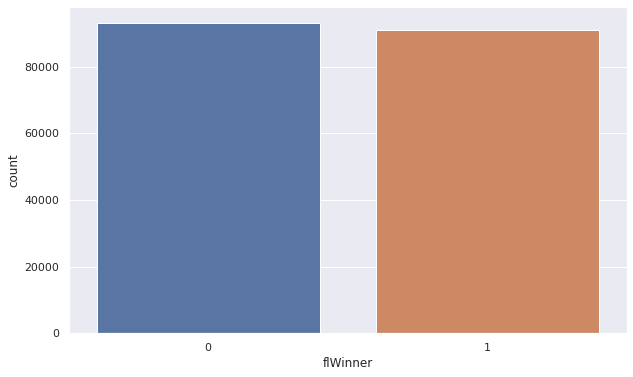

In [41]:
sns.countplot(y)

## Logistic Regression

In [42]:
# 2. Instanciar e escolher os hyperparameters
model = LogisticRegression(max_iter=138114)

# # 3.2 Padronizar os dados de treino
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# 4. Fit do modelo (treinar)
model.fit(X_train, y_train)

# 5. Fazer previsões em cima de novos dados
X_test = scaler.transform(X_test)  # padronizar os dados de teste
y_pred_log = model.predict(X_test)


# # 4. Cross-validation
# X_train_transformed = scaler.transform(X_train)
# log_score = cross_val_score(model, X_train_transformed, y_train, cv=4)
# print("scores: ", log_score)
# print("Acurácia: %0.2f (+/- %0.2f)" % (log_score.mean(), log_score.std() * 2))

In [43]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81     23250
           1       0.80      0.79      0.80     22788

    accuracy                           0.80     46038
   macro avg       0.80      0.80      0.80     46038
weighted avg       0.80      0.80      0.80     46038



Text(0.5, 30.5, 'Previsto')

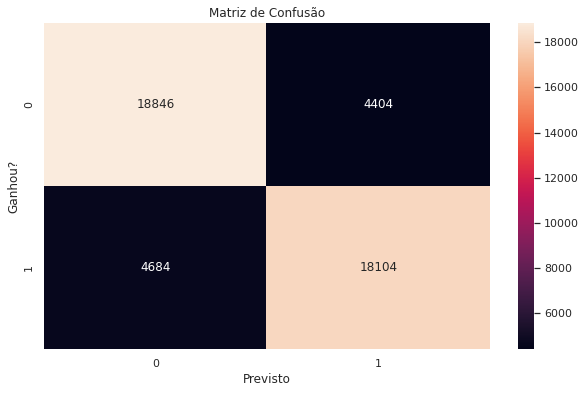

In [44]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, ax=ax, fmt='g')

ax.set_title("Matriz de Confusão")
ax.set_ylabel("Ganhou?")
ax.set_xlabel("Previsto")

## CatBoost

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

              precision    recall  f1-score   support

           0       0.80      0.83      0.81     23250
           1       0.82      0.78      0.80     22788

    accuracy                           0.81     46038
   macro avg       0.81      0.80      0.80     46038
weighted avg       0.81      0.81      0.81     46038



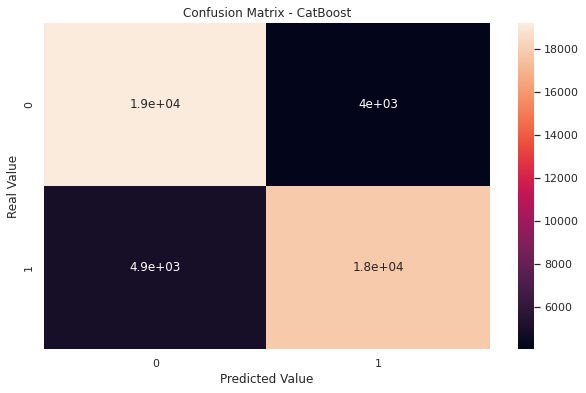

In [45]:
# Treinando o modelo
cb = CatBoostClassifier(learning_rate=0.03, depth=6, l2_leaf_reg=5, logging_level='Silent')
cb.fit(X_train, y_train)

# Prevendo
y_pred_log = cb.predict(X_test)

# classification report
print(classification_report(y_test, y_pred_log))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, ax=ax, fmt='g')
ax.set_title('Confusion Matrix - CatBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

## LightGBM

              precision    recall  f1-score   support

           0       0.78      0.80      0.79     23250
           1       0.79      0.76      0.78     22788

    accuracy                           0.78     46038
   macro avg       0.78      0.78      0.78     46038
weighted avg       0.78      0.78      0.78     46038



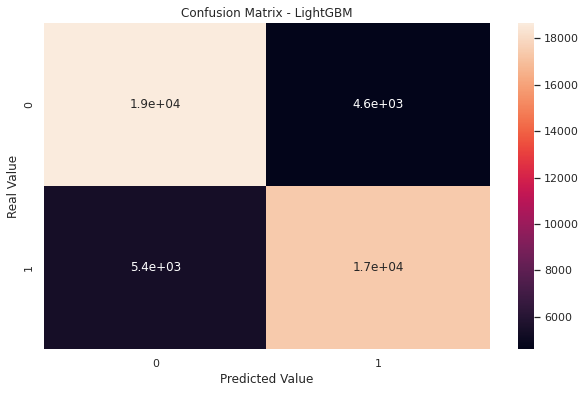

In [46]:
# Treinando o Modelo
lgb = LGBMClassifier(num_leaves=70, max_depth=5, learning_rate=0.01, min_data_in_leaf=400)
lgb.fit(X_train, y_train)

# Prevendo
y_pred_lgb = lgb.predict(X_test)

# classification report
print(classification_report(y_test, y_pred_lgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, ax=ax, fmt='g')
ax.set_title('Confusion Matrix - LightGBM')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

## XGBoost

In [47]:
# Treinando o modelo
xgb = XGBClassifier(gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50)
xgb.fit(X_train, y_train)

XGBClassifier(n_estimators=50)

In [48]:
# Prevendo
y_pred_xgb = xgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.78      0.81      0.79     23250
           1       0.80      0.77      0.78     22788

    accuracy                           0.79     46038
   macro avg       0.79      0.79      0.79     46038
weighted avg       0.79      0.79      0.79     46038



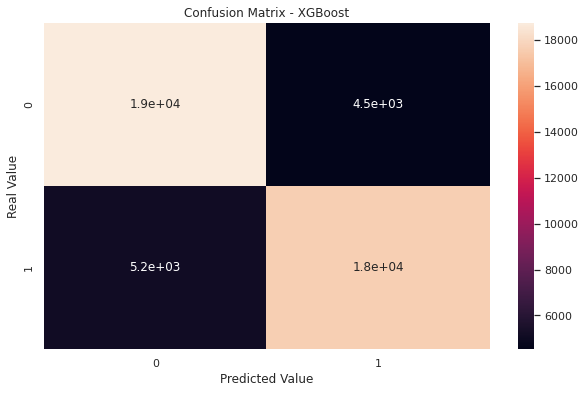

In [49]:
# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()